* Investigate why Froude No not work. Examples show the snapshot of Froude number at peak ebb/flood over the whole plume region with upper layer reaching 10 m during three different river flow periods.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import R_mixStuff as RS
import FroudeNumber as FN
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]

In [41]:
## May results
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc','r')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc','r')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc','r')

In [33]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind,ave_flag = False):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    if ave_flag == False:
        S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average at specific depth
        S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0)
    elif ave_flag == True:
        S_ref = np.nanmean(S_aveN[0:dep_ind+1]) ## then spatial average, including depth
        S_aveW = np.nanmean(np.nanmean(S[tst:ted],axis = 0),axis = 0)
    S_thre = 1.14*S_ref-4.8
    #S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [24]:
def plot_spatial(grid_T,grid_U,grid_V,t,tst,ted,dep_ind,ti,levels,lonmax,lonmin,latmax,latmin,flag):
    """Spatial plot of Fr number if flag = 'Fr', baroclinic velocity if flag = 'baroclinic',
    internal wave speed if flag = 'internal'"""
    Fr,to_speed_inte,rho_inte,g_prime= FN.Fr_No(grid_T,grid_U,grid_V,t,dep_ind,ti)
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    fig,ax = plt.subplots(1,1,figsize = (8,5))
    ## below are time averaged variable
    if flag =='Fr': ## 
        snapshot = Fr[ti]
        string = 'Froude Number'
    elif flag =='momentum':
        snapshot = to_speed_inte[ti]/rho_inte[ti]
        string = 'momentum [m/s]'
    elif flag == 'internal':
        snapshot = np.sqrt(g_prime[ti]*dep[dep_ind])
        string = 'Internal wave speed [m/s]'
    CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,levels,cmap = 'jet',extend='both')
    CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
    cbar = fig.colorbar(CS,ax = ax)
    cbar.add_lines(CS2)
    cbar.set_label(string)
    
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre-2,S_thre,S_thre+2], colors='m',linewidths=(2,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([lonmin,lonmax])
    ax.set_ylim([latmin,latmax])
    return snapshot

In [46]:
def plot_together(grid_T,grid_U,grid_V,t,tst,ted,dep_ind,ti,levels_Fr,levels_M,levels_B,lonmax,lonmin,latmax,latmin):
    """Plot ssh at PA, Froude number, momentum and buoyancy together for 
    three different flow periods"""
    Fr,to_speed_inte,rho_inte,g_prime= FN.Fr_No(grid_T,grid_U,grid_V,t,dep_ind,ti)
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    fig, axs = plt.subplots(1,3,figsize = (20,5))
    for ax, snapshot, string,level in zip(axs,[Fr[ti],to_speed_inte[ti]/rho_inte[ti],np.sqrt(g_prime[ti]*dep[dep_ind])],\
                                    ['Froude Number','momentum [m/s]','buoyancy [m/s]'],[levels_Fr,levels_M,levels_B]):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,level,cmap = 'jet',extend='both')
        CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
        cbar = fig.colorbar(CS,ax = ax)
        cbar.add_lines(CS2)
        cbar.set_label(string)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])
    ax = axs[0]
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='m',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)

# Peak ebb

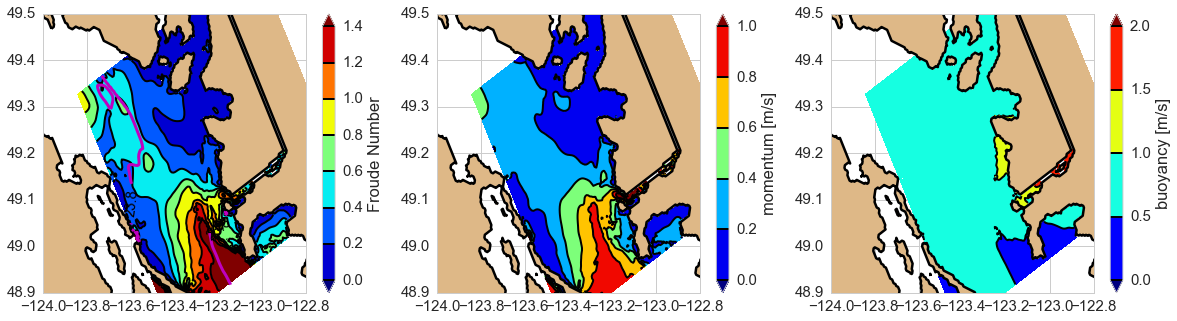

In [53]:
## Oct
levels_Fr = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
levels_M = [0,0.2,0.4,0.6,0.8,1]
levels_B = [0,0.5,1,1.5,2]
plot_together(all_T,all_U,all_V,196,196,197,10,'all',levels_Fr,levels_M,levels_B,-122.8,-124.,49.5,48.9)

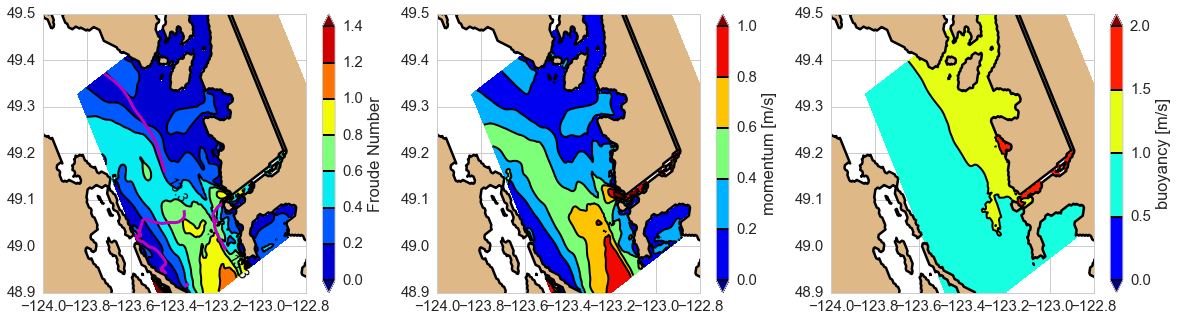

In [47]:
## May
plot_together(all_T,all_U,all_V,734,734,735,10,'all',levels_Fr,levels_M,levels_B,-122.8,-124.,49.5,48.9)

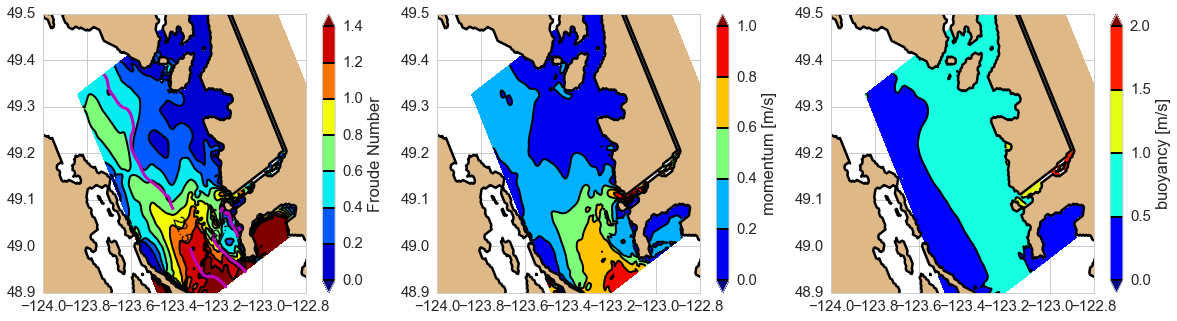

In [50]:
## Jan
plot_together(all_T,all_U,all_V,195,195,196,10,'all',levels_Fr,levels_M,levels_B,-122.8,-124.,49.5,48.9)

# Peak flood

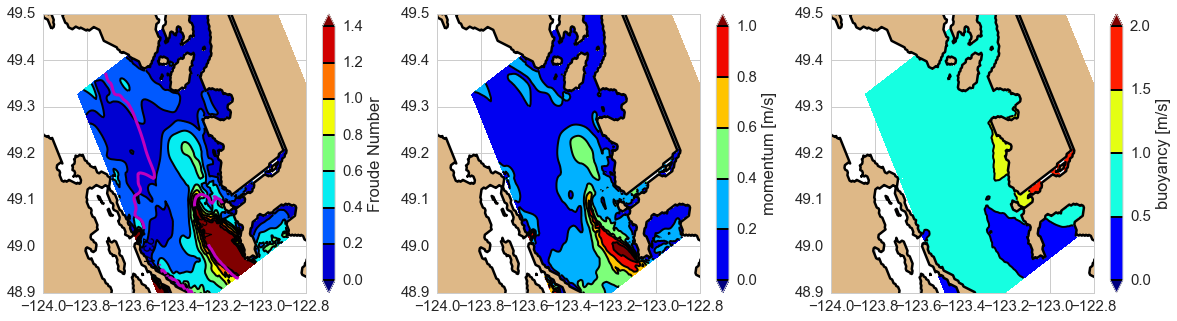

In [54]:
## Oct
plot_together(all_T,all_U,all_V,202,202,203,10,'all',levels_Fr,levels_M,levels_B,-122.8,-124.,49.5,48.9)

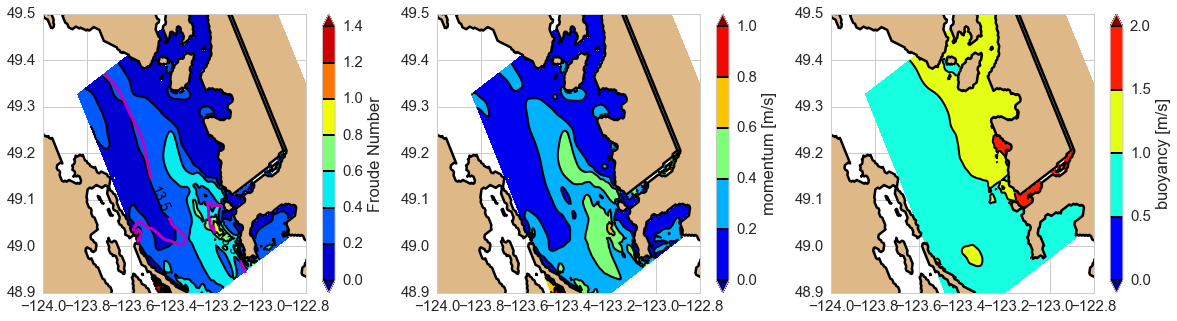

In [48]:
## May
plot_together(all_T,all_U,all_V,741,741,742,10,'all',levels_Fr,levels_M,levels_B,-122.8,-124.,49.5,48.9)

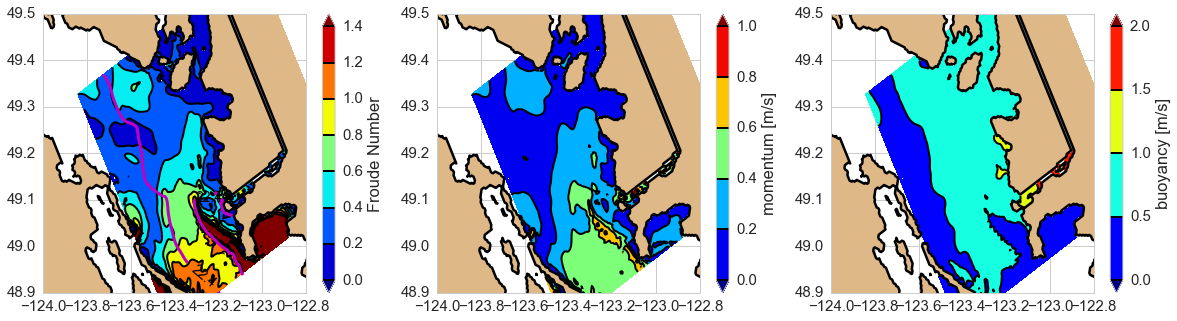

In [51]:
## Jan
plot_together(all_T,all_U,all_V,202,202,203,10,'all',levels_Fr,levels_M,levels_B,-122.8,-124.,49.5,48.9)

* $Fr = \frac{u}{\sqrt{g^{'}h}}$, where u is the weighted total velocity of upper layer $\frac{\int\Delta\rho\sqrt{u^2+v^2}dz}{\int\Delta\rho dz}$, here $\Delta\rho$ is the density difference between reference $\rho_0$ and this layer,  $g^{'} = g\frac{\Delta \rho}{\rho_{0}}$, $\Delta\rho = \rho_{0} - \frac{\int\rho dz}{\int dz}$, where both numerator and denominator take into account ssh variation.

# Depth 10m in May

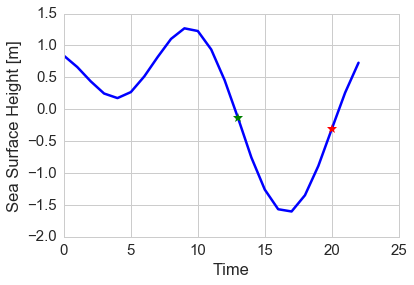

In [7]:
ssh = all_T.variables['sossheig'] ## may last day
plt.plot(ssh[-23:,86,89],'-b')
plt.plot(13,ssh[734,86,89],'g*',markersize = 10) ## peak ebb
plt.plot(20,ssh[741,86,89],'r*',markersize = 10) ## peak flood
plt.ylabel('Sea Surface Height [m]')
plt.xlabel('Time') ## wind is weak that day

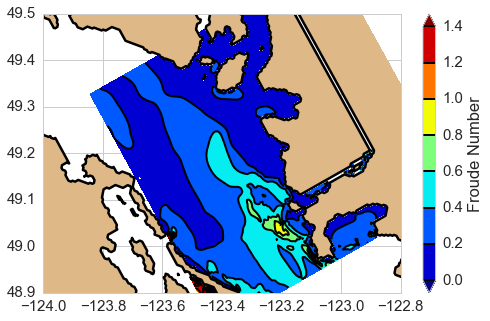

In [5]:
## peak flood tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = FN.plot_spatial(all_T,all_U,all_V,741,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

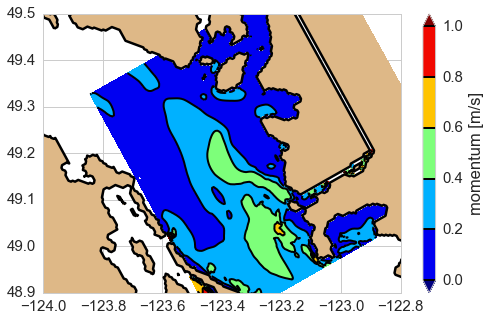

In [6]:
## peak flood tide momentum 
levels = [0,0.2,0.4,0.6,0.8,1]
tospeed = FN.plot_spatial(all_T,all_U,all_V,741,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

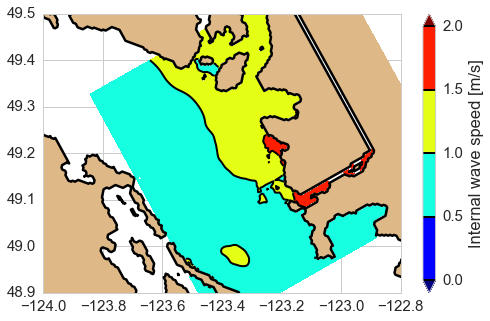

In [8]:
## peak flood tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = FN.plot_spatial(all_T,all_U,all_V,741,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')

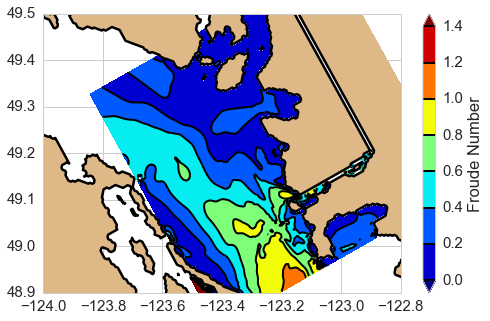

In [9]:
## peak ebb tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = FN.plot_spatial(all_T,all_U,all_V,734,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

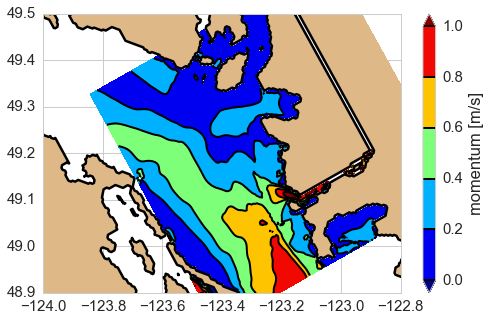

In [13]:
## peak ebb tide momentum 
levels = [0,0.2,0.4,0.6,0.8,1]
tospeed = FN.plot_spatial(all_T,all_U,all_V,734,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

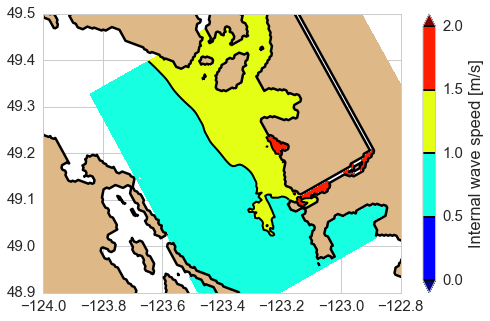

In [11]:
## peak ebb tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = FN.plot_spatial(all_T,all_U,all_V,734,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')

* Peak ebb: momentum southward (river outflow + ebb tides) dominant, buoyancy dominant in the river and northward of mouth (other river sources + Coriolis force?), indicating already mixed southward water.
* Peak flood: momentum weak, buoyancy forcing goes northward, suggesting subcritical flows.
* Very intesting block of buoyancy forcing shows up during peak ebb and disappears during peak flood, showing flood tides restrict the river going out.

# Dep 10m Jan

In [49]:
## Jan results
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc','r')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc','r')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc','r')

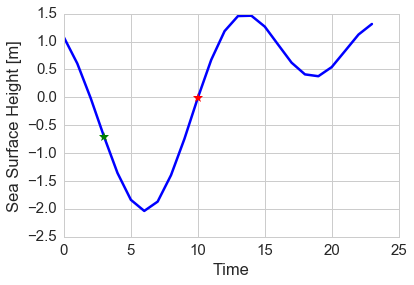

In [15]:
ssh = all_T.variables['sossheig'] ## Jan 9~10, spring tide
plt.plot(ssh[24*8:24*9,86,89],'-b')
plt.plot(3,ssh[24*8+3,86,89],'g*',markersize = 10) # peak ebb
plt.plot(10,ssh[24*8+10,86,89],'r*',markersize = 10) # peak flood
plt.ylabel('Sea Surface Height [m]')
plt.xlabel('Time') ## wind is weak that day

S_ref 23.879
S_thre 22.4220227051


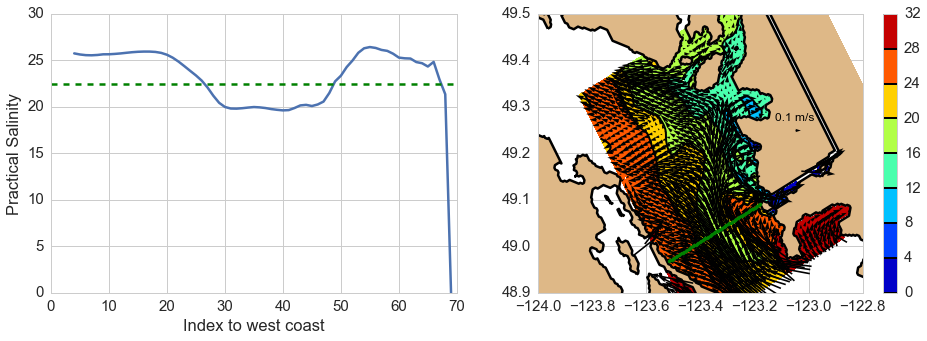

In [16]:
import DetermineEdgePlume as DEP
DEP.determine_plume_method2(all_T,all_U,all_V,202,203,0,0.2) ## Jan 9~10, early spring, peak flood

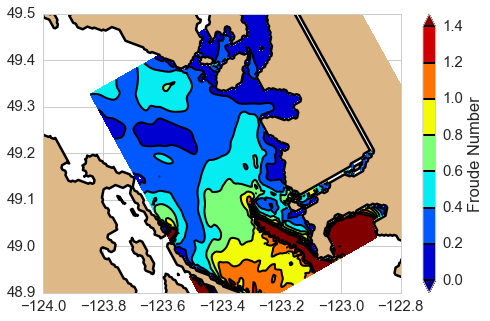

In [17]:
## peak flood tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = FN.plot_spatial(all_T,all_U,all_V,202,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

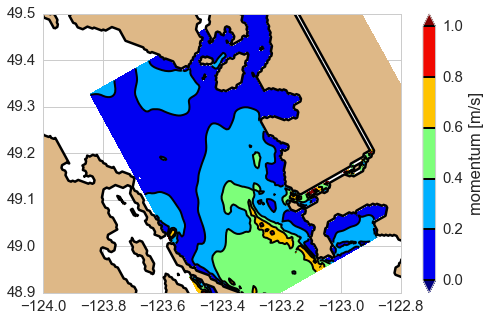

In [18]:
## peak flood tide momentum 
levels =[0,0.2,0.4,0.6,0.8,1]
tospeed = FN.plot_spatial(all_T,all_U,all_V,202,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

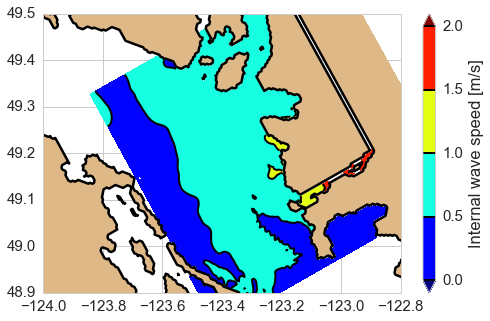

In [19]:
## peak flood tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = FN.plot_spatial(all_T,all_U,all_V,202,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')

i,lon,real salinity 30 -123.381 22.6145
S_ref 23.9561
S_thre 22.5099936676


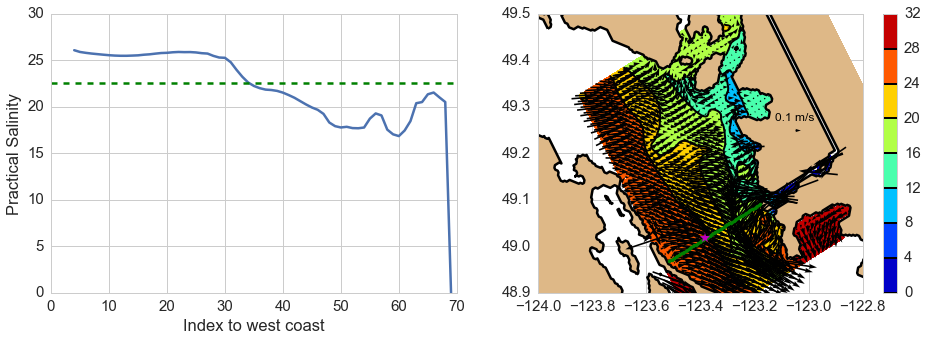

In [20]:
DEP.determine_plume_method2(all_T,all_U,all_V,195,196,0,0.2) ## Jan 9~10, early spring, peak ebb

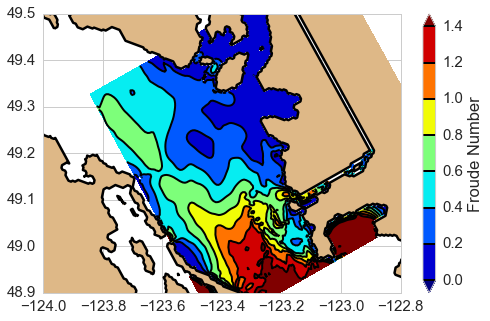

In [21]:
## peak ebb tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = FN.plot_spatial(all_T,all_U,all_V,195,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

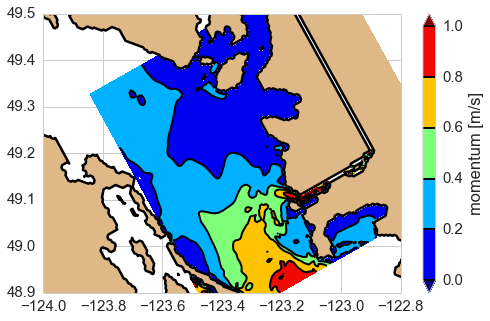

In [22]:
## peak ebb tide momentum 
levels = [0,0.2,0.4,0.6,0.8,1]
tospeed = FN.plot_spatial(all_T,all_U,all_V,195,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

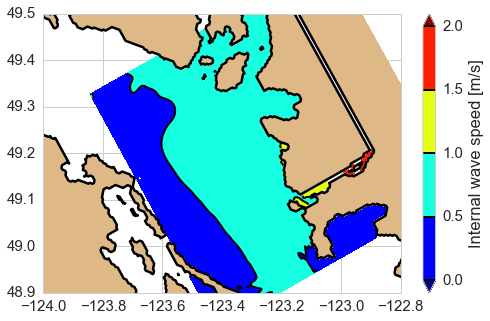

In [23]:
## peak ebb tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = FN.plot_spatial(all_T,all_U,all_V,195,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')

# Dep 10m in Oct

In [52]:
## Oct results
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc','r')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc','r')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc','r')

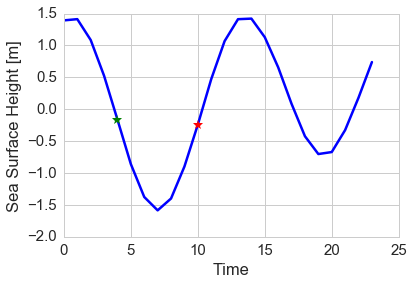

In [27]:
ssh = all_T.variables['sossheig'] ## Oct 9
plt.plot(ssh[24*8:24*9,86,89],'-b')
plt.plot(4,ssh[24*8+4,86,89],'g*',markersize = 10) ## peak ebb
plt.plot(10,ssh[24*8+10,86,89],'r*',markersize = 10) ## peak flood
plt.ylabel('Sea Surface Height [m]')
plt.xlabel('Time') ## wind is weak that day

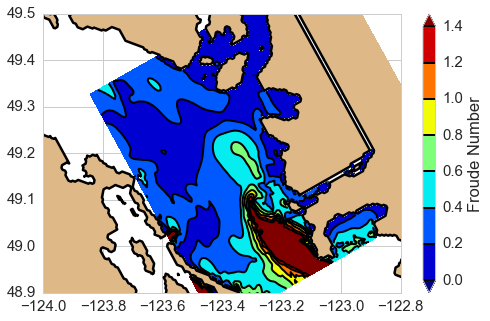

In [28]:
## peak flood tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = FN.plot_spatial(all_T,all_U,all_V,202,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

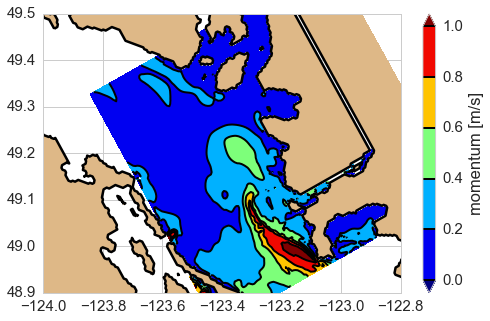

In [29]:
## peak flood tide momentum 
levels = [0,0.2,0.4,0.6,0.8,1]
tospeed = FN.plot_spatial(all_T,all_U,all_V,202,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

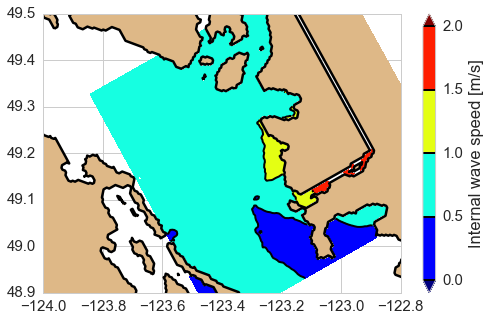

In [30]:
## peak flood tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = FN.plot_spatial(all_T,all_U,all_V,202,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')

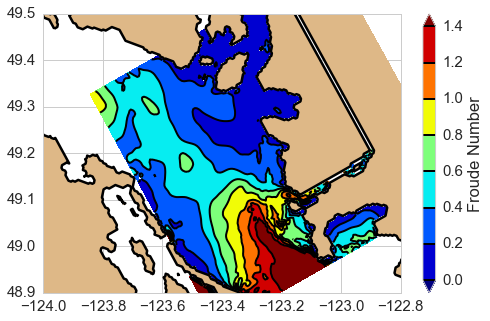

In [31]:
## peak ebb tide Fr number
levels = [0,0.2,0.4,0.6,0.8,1,1.2,1.4]
Fr = FN.plot_spatial(all_T,all_U,all_V,196,10,'all',levels,-122.8,-124.,49.5,48.9,'Fr')

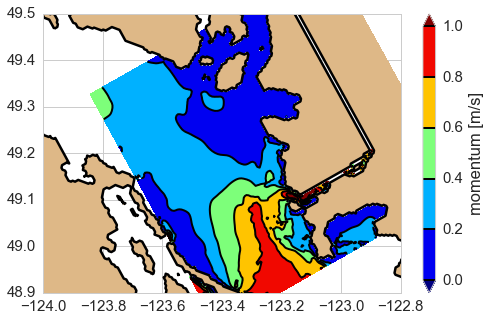

In [33]:
## peak ebb tide momentum 
levels = [0,0.2,0.4,0.6,0.8,1]
tospeed =FN.plot_spatial(all_T,all_U,all_V,196,10,'all',levels,-122.8,-124.,49.5,48.9,'momentum')

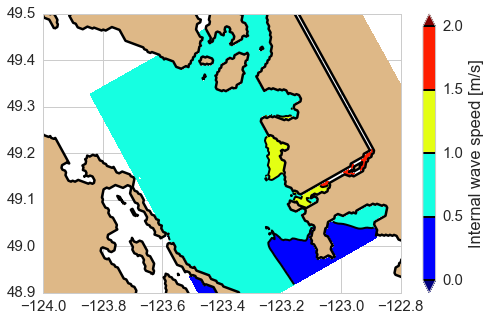

In [34]:
## peak ebb tide internal wave speed
levels = [0,0.5,1,1.5,2]
iws = FN.plot_spatial(all_T,all_U,all_V,196,10,'all',levels,-122.8,-124.,49.5,48.9,'internal')